In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
from dateparser import parse
import re
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
import shap
from sklearn.metrics import r2_score
from sklearn.base import clone
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer

In [2]:
# Load data
tweet_data = pd.read_csv("Prabowo_All2.csv", delimiter='\t', header=None, names=['data'])
tweet_data = tweet_data['data'].str.split(';', expand=True)
tweet_data.columns = ['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count',
                      'retweet_count', 'favorite_count', 'lang', 'user_id_str',
                      'conversation_id_str', 'username', 'tweet_url']

# Function for text preprocessing
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    
    # Remove stopwords
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    text = stopword_remover.remove(text)
    
    return text

# Apply text preprocessing to your data
tweet_data['cleaned_full_text'] = tweet_data['full_text'].astype(str).apply(preprocess_text)

# Load survey data
survey_data = pd.read_excel('Electionforcode_Prabowo3.xlsx')
tweet_data['date'] = pd.to_datetime(tweet_data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
tweet_data = tweet_data.dropna(subset=['date'])

# Extract the 'Numbers of Candidate' column
numbers_of_candidate = survey_data['Numbers of Candidate']

# Assuming the "Polling firm" column exists in your survey data
survey_data['Polling firm'] = survey_data['Polling firm'].astype(str)

# Perform one-hot encoding on the "Polling firm" column
survey_data = pd.get_dummies(survey_data, columns=['Polling firm'], prefix='polling')

def preprocess_text_eng(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    

    # Remove English stopwords
    english_stopwords = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in english_stopwords]
    text = ' '.join(filtered_words)
    
    return text

file_data = pd.read_excel('Phenomena2.xlsx')
file_data['cleaned_Phenomenon'] = file_data['Phenomenon'].astype(str).apply(preprocess_text_eng)
file_data['date'] = pd.to_datetime(file_data['Date'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
file_data = file_data.dropna(subset=['date'])

# Prepare features (X) and target (y)
lsa_results = []  
survey_results = []  
n_components = 43  
lsa = TruncatedSVD(n_components=n_components)

In [3]:
survey_data['year'] = survey_data['Date Range'].apply(lambda x: parse(x.split('-')[0]).year)
file_data['year'] = file_data['Date'].dt.year

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Top-10 most important features:
['lsa_tweet_ahli', 'lsa_tweet_ajak', 'lsa_tweet_adil', 'lsa_tweet_ada', 'lsa_tweet_akhirnya', 'lsa_tweet_agreement', 'lsa_tweet_adalah', 'lsa_tweet_ajang', 'lsa_tweet_ah', 'lsa_tweet_abdul']


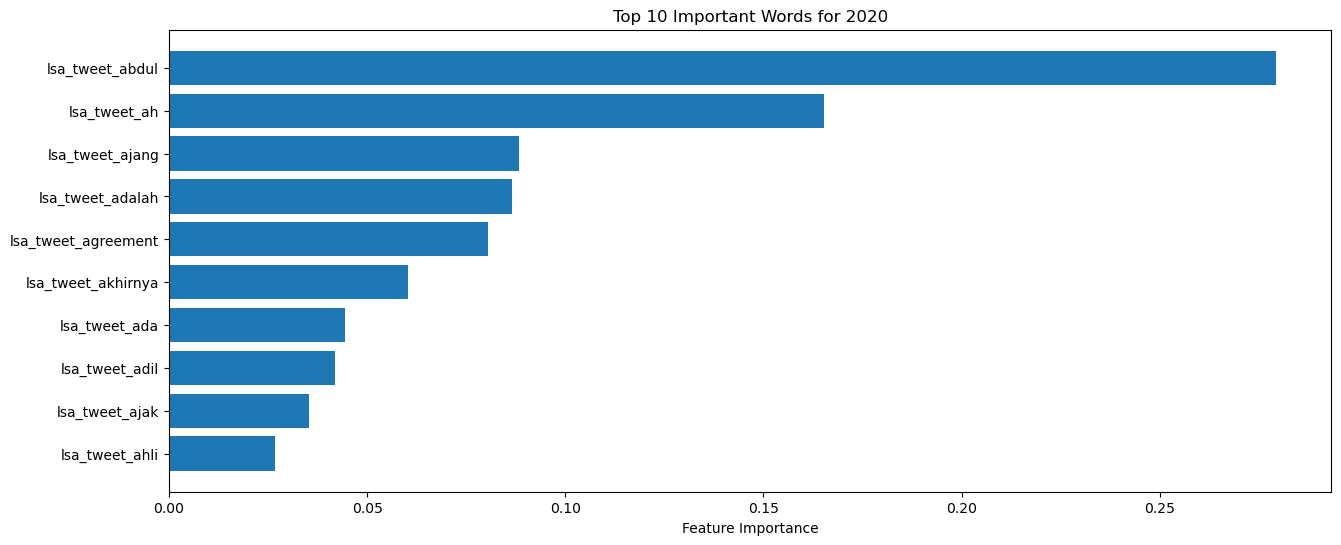

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Top-10 most important features:
['lsa_tweet_aja', 'lsa_tweet_aku', 'lsa_tweet_andrerosiade', 'lsa_tweet_an', 'lsa_tweet_amp', 'lsa_tweet_amin', 'lsa_tweet_ado', 'lsa_tweet_ambo', 'lsa_tweet_adi', 'lsa_tweet_ada']


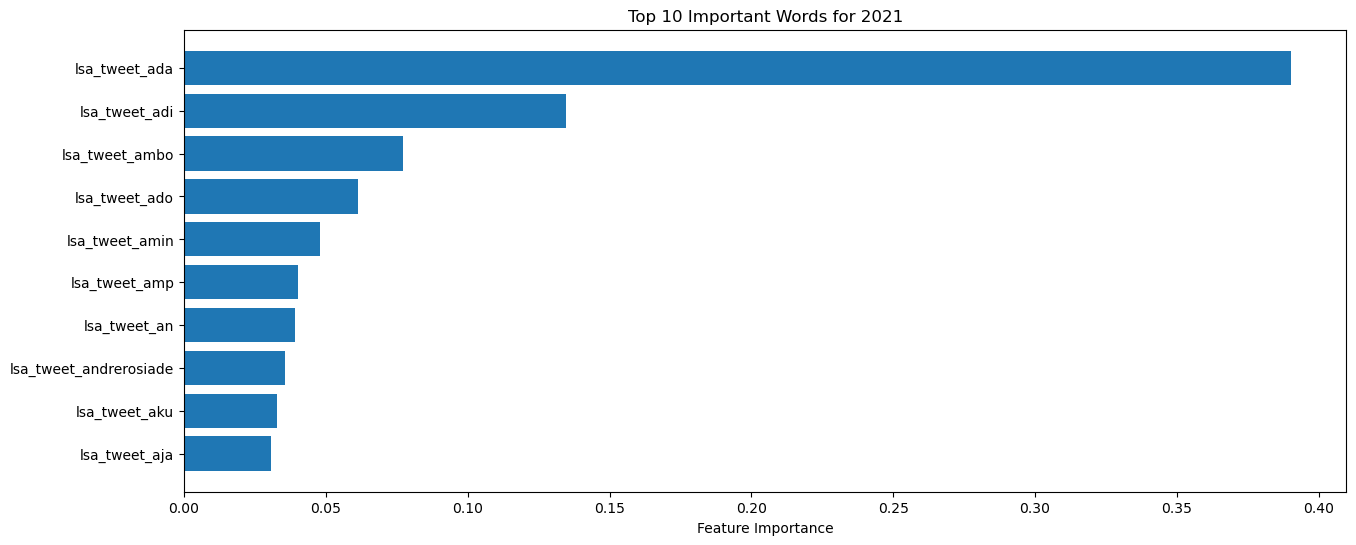

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Top-10 most important features:
['lsa_tweet_agar', 'lsa_tweet_ada', 'lsa_tweet_aja', 'lsa_tweet_airlanggahrt', 'lsa_tweet_abdurachman', 'lsa_tweet_ad', 'lsa_tweet_ajak', 'lsa_tweet_ahokdjarot', 'lsa_tweet_aamiin', 'lsa_tweet_airlangga']


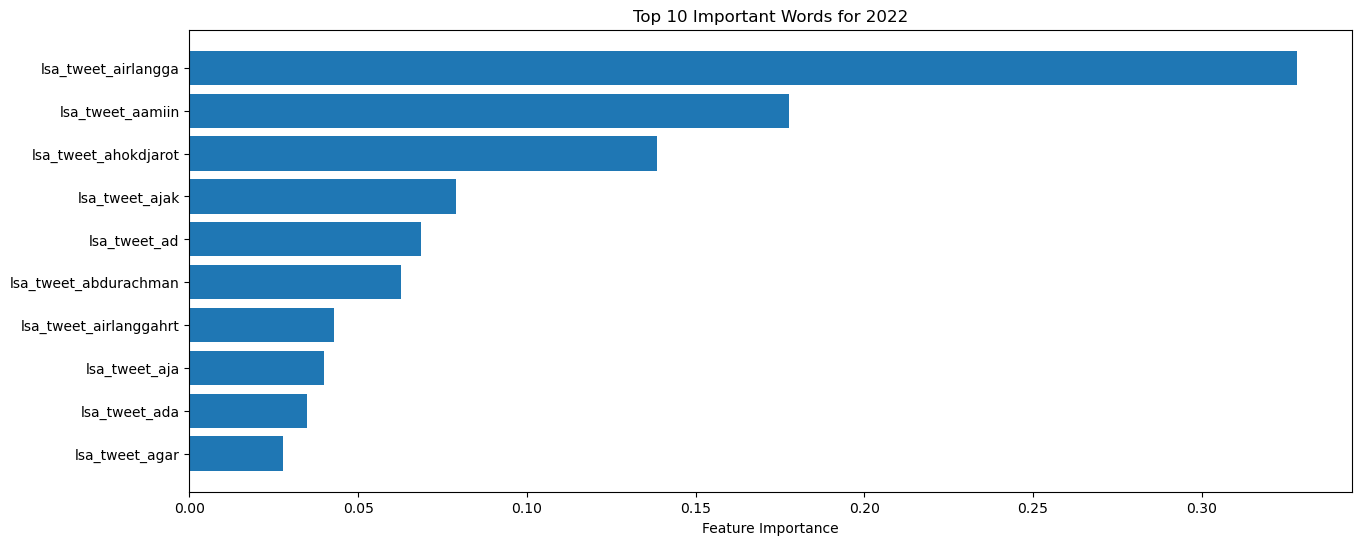

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Top-10 most important features:
['lsa_tweet_adalah', 'lsa_tweet_adu', 'lsa_tweet_adl', 'lsa_tweet_ada', 'lsa_tweet_abgg', 'lsa_tweet_ahok', 'lsa_tweet_acara', 'lsa_tweet_adanya', 'lsa_tweet_abadi', 'lsa_tweet_adik']


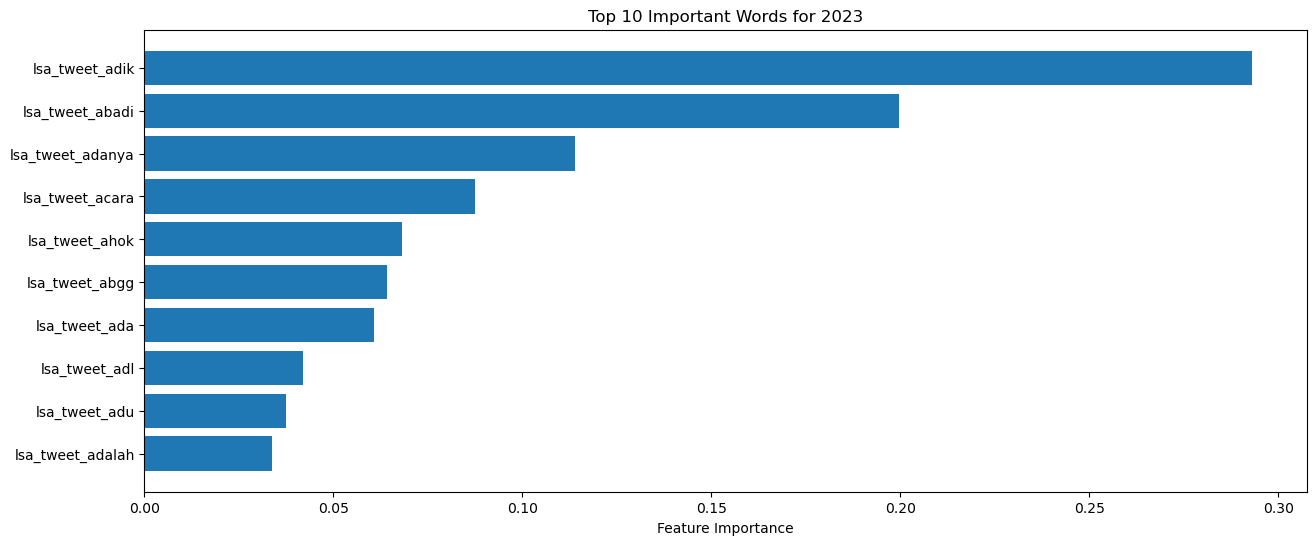

In [6]:
# Create subsets for each year in file_data
for year in range(2020, 2024):  
    file_data_yearly = file_data[file_data['year'] == year]
    survey_data_yearly = survey_data[survey_data['year'] == year]
    for index, row in survey_data_yearly.iterrows():
        date_range = row['Date Range']
        date_parts = date_range.split('-')
        start_date_str = date_parts[0].strip()
        end_date_str = date_parts[1].strip()
        start_date = parse(start_date_str)
        end_date = parse(end_date_str)
    
        # Define the tweet date range
        tweet_start_date = start_date - timedelta(days=7)
        tweet_end_date = end_date + timedelta(days=7)
    
        # Filter tweets within the date range
        tweets_in_interval = tweet_data[(tweet_data['date'] >= tweet_start_date) & (tweet_data['date'] <= tweet_end_date)]
 
        # Extract cleaned text as a list
        cleaned_texts = tweets_in_interval['cleaned_full_text'].astype(str).tolist()
    
        # Create and fit the TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)
    
        # Perform TruncatedSVD (LSA)
        lsa_matrix = lsa.fit_transform(tfidf_matrix)
    
        # Calculate the average LSA for the tweets in the interval
        avg_lsa = np.mean(lsa_matrix, axis=0)
    
        # Get the one-hot encoded features for the "Polling firm"
        polling_firm_features = row.filter(like='polling_').values
    
        # Get the 'Numbers of Candidate' feature
        numbers_of_candidate_value = row['Numbers of Candidate']
    
        # Define the tweet date range
        Event_start_date = start_date - timedelta(days=17)
        Event_end_date = end_date 
    
        # Filter tweets within the date range
        Events_in_interval = file_data[(file_data['date'] >= Event_start_date) & (file_data['date'] <= Event_end_date)]
    
        # Extract cleaned text as a list
        cleaned_events = Events_in_interval['cleaned_Phenomenon'].astype(str).tolist()
    
        # Fit the TF-IDF vectorizer for events
        tfidf_vectorizer2 = TfidfVectorizer(max_features=1000)
        tfidf_matrix2 = tfidf_vectorizer2.fit_transform(cleaned_events)
    
        # Perform TruncatedSVD (LSA) for events
        lsa_matrix2 = lsa.fit_transform(tfidf_matrix2)
        
        # Calculate the average LSA for the events in the interval
        avg_lsa2 = np.mean(lsa_matrix2, axis=0)
    
        # Append the results to the lists, including the polling firm features
        lsa_results.append(np.concatenate((avg_lsa, polling_firm_features, [numbers_of_candidate_value])))
        survey_results.append(row)
    
    # Convert the yearly results to NumPy arrays
    X = np.array(lsa_results)
    y = np.array(survey_results)
    
    # Specify the maximum length for padding
    max_length = max(len(x) for x in X)

    # Initialize an empty list to store padded arrays
    X_padded = []

    # Pad the arrays to the maximum length
    for x in X:
        if len(x) < max_length:
            padding_length = max_length - len(x)
            x_padded = np.pad(x, (0, padding_length), 'constant', constant_values=0)
            X_padded.append(x_padded)
        else:
            X_padded.append(x)

    # Convert X to a NumPy array
    X = np.array(X_padded)

    # Extract the target variable from survey results
    y = y[:, 1]  
    y = np.array(y, dtype=float)
    
    # Define the number of splits for time series cross-validation
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    # Initialize lists to store predictions for each fold
    y_pred_rf = []

    y_true = []  # Initialize a list to store true target value
    # Perform time series cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create separate pipelines for each model
        pipeline_rf = Pipeline([
            ('svd', TruncatedSVD(n_components=15)),  
            ('rf', RandomForestRegressor(n_estimators=110, max_depth=10, random_state=42))  
        ])
    
        # Hyperparameter tuning for Random Forest
        param_grid_rf = {
            'svd__n_components': [10, 15, 20],
            'rf__n_estimators': [100, 150, 200],
            'rf__max_depth': [5, 10, 15]
        }
    
        grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv)
        grid_search_rf.fit(X_train, y_train)

        # Predict for the current fold
        y_pred_rf_fold = grid_search_rf.predict(X_test)

        # Append the predictions to the lists
        y_pred_rf.extend(y_pred_rf_fold)
        y_true.extend(y_test)

    # Fit the grid search to the entire dataset
    grid_search_rf.fit(X, y)

    # Get the best estimator from the grid search
    best_rf_estimator = grid_search_rf.best_estimator_

    # Get feature importances for the current year
    feature_importances_yearly = best_rf_estimator.named_steps['rf'].feature_importances_

    # Get the corresponding words from the TF-IDF vectorizer
    tfidf_feature_names_yearly = tfidf_vectorizer.get_feature_names_out()

    # Choose the top-k important features
    k = 10
    top_k_features = np.argsort(feature_importances_yearly)[-k:]

    # Create a list to store the formatted feature names with actual words
    formatted_feature_names = []

    # Format the feature names with the appropriate prefix and actual words
    for feature_index in top_k_features:
        if feature_index < n_components:
            word = f'lsa_tweet_{tfidf_feature_names_yearly[feature_index]}'  
            formatted_feature_names.append(word)
        elif n_components <= feature_index < 2 * n_components:
            word = f'lsa_event_{feature_index - n_components}'  
            formatted_feature_names.append(word)
        elif 2 * n_components <= feature_index < 2 * n_components + len(polling_firm_feature_names):
            word = polling_firm_feature_names[feature_index - 2 * n_components]
            formatted_feature_names.append(word)
        else:
            word = f'lsa_tweet_{tfidf_feature_names_yearly[feature_index]}'  # Combine prefix with actual word
            formatted_feature_names.append(word)

    # Print the formatted feature names
    print(f"Top-{k} most important features:")
    print(formatted_feature_names)

    # Plot the top-k important features in a single bar chart
    plt.figure(figsize=(15, 6))
    plt.barh(range(k), feature_importances_yearly[top_k_features], align='center', tick_label=formatted_feature_names)
    plt.xlabel('Feature Importance')
    plt.title(f"Top {k} Important Words for {year}")
    plt.show()